# Image restauration

## Introduction

**Image restoration** is the idea of recovering an original image from a _degraded image_, knowing the process of degradation beforehand. The recovered image is called the _restored image_.

Let $F$ be a matrix that represents the original photo (with $f$ as a line array of the image), $G$ be the degraded image (with $g$ as a line), and $\hat F$ be the restored image. The degradation process involves a uniform horizontal movement.

$$
g_i = (f_i + f_{i + 1} + ... + f_{i + n - 1})/n
$$Let $H$ be a matrix that represent the movement, so that $g = Hf$.$ .

$$
g = H*f = \begin{bmatrix}
h_1 & \dots & h_n & 0 & 0 & 0 &  0 \\
0 & h_1 & \dots & h_n  & 0 & 0 & 0 \\
& & \vdots   & &   \vdots \\
0 & 0 & \dots & h_1 & \dots & h_n 
\end{bmatrix} 
\begin{bmatrix}
f_1 \\
f_2 \\
\vdots \\
f_n
\end{bmatrix} =
\begin{bmatrix}
g_1 \\
g_2 \\
\vdots \\
g_n
\end{bmatrix} 
$$If $M$ is the number of columns of $F$ and $n$ represents the displacement, then the number of columns $N$ in $G$ is given by $N = M - n + 1$.

Given G, recovery $\hat F \approx F$

$$
Hf = g \rightarrow f = H^{-1}g 
$$

he solution $\hat f$ must satisfy:

1. $H\hat f = g$
2. $riz(\hat f) \rightarrow min$1$

In [1]:
from IPython.display import display
import numpy as np
from PIL import Image

In [2]:
def show_img(img_array):
    """Display the image"""
    img = Image.fromarray(img_array, 'L')
    display(img)

def fix_array(arr):
    """Ensure the array is proper for image display"""
    arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) * 255
    arr = arr.astype('uint8')
    return arr

## Get G and H

1. Pick an image and import it as black and white. Then, get an array (F) from the image.
2. Using the sizes of F, generate the model H
3. Create G

In [3]:
def generate_H(N, M, n):
    H = []
    for i in range(N):
        row = [0] * M 
        
        for j in range(i, i + n):
            if (j < M): row[j] = 1/n
            
        H.append(row)
    return np.matrix(H)

### The original image F

[[  0   0   0 ...  37  38  34]
 [  0   0   0 ...  37  37  36]
 [  0   0   0 ...  37  37  36]
 ...
 [104  96  94 ...  58  55  54]
 [113 112 109 ...  55  44  59]
 [112 121 123 ...  58  58  55]] (362, 272)


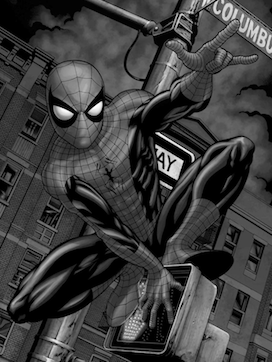

In [27]:
img = Image.open('./img/spiderman.png').convert('L')

F = np.asarray(img)
F = fix_array(F)
print(F, F.shape)
img_F = show_img(F)

### Get the model

In [13]:
n = 50

M = len(F[0])
N = M - n +1
print(f"M = {M} N = {N}")

H = generate_H(N, M, n)
print(H, H.shape)

M = 272 N = 223
[[0.02 0.02 0.02 ... 0.   0.   0.  ]
 [0.   0.02 0.02 ... 0.   0.   0.  ]
 [0.   0.   0.02 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.02 0.   0.  ]
 [0.   0.   0.   ... 0.02 0.02 0.  ]
 [0.   0.   0.   ... 0.02 0.02 0.02]] (223, 272)


### Generate G

[[  6   6   7 ... 128 127 122]
 [  6   6   6 ... 134 132 128]
 [  6   6   7 ... 139 137 132]
 ...
 [130 134 137 ... 112 110 107]
 [126 129 131 ... 113 111 108]
 [128 131 132 ... 115 113 111]] (362, 223)


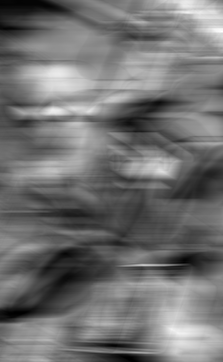

In [14]:
G = (H@F.T).transpose()
G = fix_array(G)

print(G, G.shape)
img_G = show_img(G)

In [7]:
img = Image.fromarray(G, 'L')
img.save('./img/spiderman_degraded.png')

## Restauration

[[124 103 127 ... 141 136 164]
 [122 125 113 ... 153 141 155]
 [124 110 129 ... 152 145 148]
 ...
 [160 165 168 ... 151 168 156]
 [167 174 172 ... 170 144 158]
 [172 179 172 ... 153 160 170]] (362, 271)


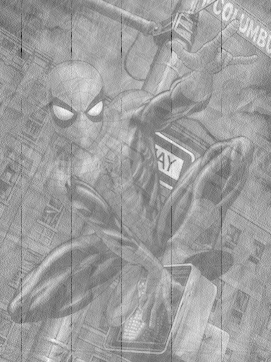

In [15]:
H_ = np.delete(H, M-1, axis=1)
H_inv = np.linalg.pinv(H_)
F_hat = H_inv@G.transpose()

F_hat = fix_array(F_hat).transpose()
print(F_hat, F_hat.shape)
show_img(F_hat)

### Closed form

$$
\displaylines{
V(f) = \lambda || Hf - g ||^2 + ||f||^2 \rightarrow min \\
\frac{\partial}{\partial f} V(f) = 2\lambda H^T(Hf - g) + 2W^TWf = 0 \\
\hat f = \underbrace{\lambda [\lambda H ^TH+ W^TW]^{-1}H^T}_{A}g = Ag
}
$$

For the whole image 
$$
\hat F = G A^T
$$

[[ 51  18  54 ...  70 113  66]
 [ 48  51  33 ...  77  99  85]
 [ 51  29  58 ...  84  88  73]
 ...
 [107 115 119 ... 118 100  85]
 [118 129 126 ...  82 104  85]
 [125 136 125 ... 107 121 106]] (362, 272)


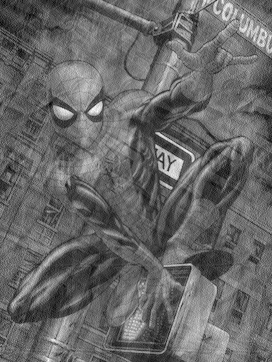

In [41]:
lmbda = 10**6
W = np.eye(M)
A = lmbda * np.linalg.inv(lmbda * np.dot(H.T, H) + np.dot(W.T, W)).dot(H.T)
F_hat = G@A.transpose()

F_hat = fix_array(F_hat)
print(F_hat, F_hat.shape)
F_closed = F_hat
img_closed = show_img(F_hat)

### Gradient Descent


Coast function 

$$
V(\hat f) = lambda * ||\hat Hf - g||^2 + ||\hat f||^2
$$

Find the gradient 

$$
\displaylines{
\nabla V(\hat f) = lambda * ||\hat Hf - g||^2 + ||\hat f||^2 \\
= 2\lambda H^T(Hf - g) + 2W^TWf \\
}
$$

Gradient descent algorithm 
$$
\hat f_{k+1} = \hat f_{k} - \alpha * \nabla V(\hat f_{k})
$$

break at 999
[[ 27  22  26 ...  68  70  52]
 [ 28  23  21 ...  75  71  56]
 [ 26  18  18 ...  76  69  51]
 ...
 [ 63  79  90 ...  76  69  54]
 [ 71  91  99 ...  70  65  52]
 [ 74  99 110 ...  77  70  58]] (362, 272)


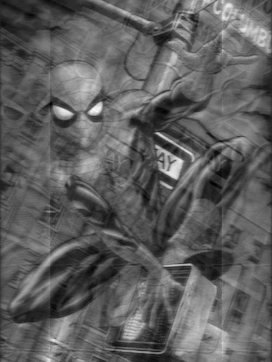

In [40]:
lmbda = 1000
alpha = 0.001
tol = 10**(-4)
max_iter = 10**3

W = np.eye(M)
F_hat = np.zeros((G.shape[0], H.shape[1]))

for i in range(max_iter):
    gradient = 2 * lmbda * H.T @ (H @ F_hat.T - G.T) + 2* (W.T @ (W @ F_hat.T))
    F_hat = F_hat - alpha * gradient.T
    
    if np.linalg.norm(gradient) < tol:
        break

print(f"break at {i}")
F_hat = fix_array(F_hat)
print(F_hat, F_hat.shape)
F_gradient = F_hat
img_gradient = show_img(F_hat)

### Newton$

$$
\displaylines{
V(f) = \lambda || Hf - g ||^2 + ||f||^2 \rightarrow min \\
f_{k + 1} = f_k -[\frac{\partial^2}{\partial f^2}  V(f)]^{-1}\frac{\partial}{\partial f}  V(f)' \\ 
\frac{\partial}{\partial f} V(f) = \nabla V(f) = 2\lambda H^T(Hf - g) + 2W^TWf \\
\frac{\partial^2}{\partial f^2} V(f) = \nabla^2 V(f_k) p_k = -\nabla V(f_k) = 2\lambda H^TH + 2W^TW
} 
$$

break at 1
[[ 27  22  26 ...  68  70  52]
 [ 28  23  21 ...  74  71  56]
 [ 26  18  18 ...  75  69  51]
 ...
 [ 64  80  90 ...  76  69  54]
 [ 72  91  99 ...  70  66  53]
 [ 75 100 110 ...  77  71  58]] (362, 272)


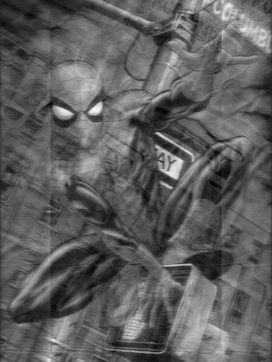

In [39]:
lmbda = 1000
tol = 10**(-6)
max_iter = 10**3

W = np.eye(M)
F_hat = np.zeros((G.shape[0], H.shape[1]))

for i in range(max_iter):
    gradient = 2 * lmbda * H.T @ (H @ F_hat.T - G.T) + 2* (W.T @ (W @ F_hat.T))
    hessian = 2*lmbda * np.dot(H.T, H) + 2*np.dot(W.T, W)
    F_hat = F_hat + np.dot(np.linalg.inv(hessian),-gradient).T
    if np.linalg.norm(gradient) < tol:
        break
print(f"break at {i}")
F_hat = fix_array(F_hat)
print(F_hat, F_hat.shape)
F_newton = F_hat
img_newton = show_img(F_hat)

## Conclusions

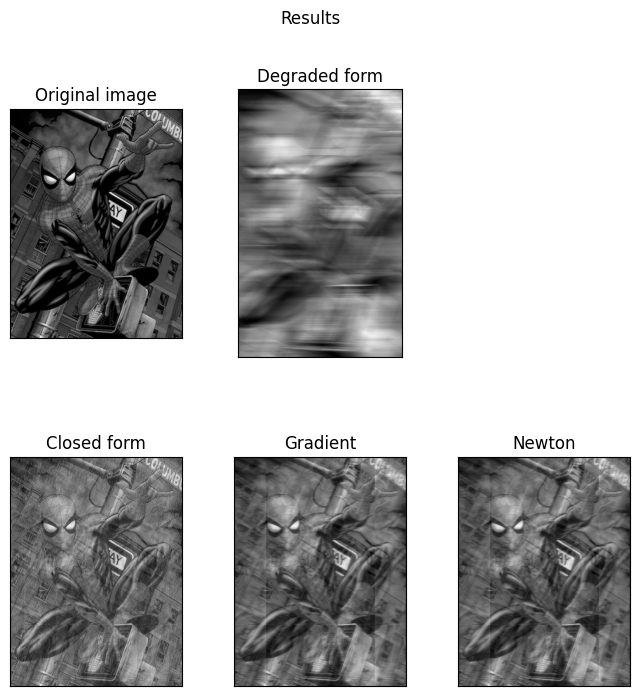

In [44]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,3, figsize=(8,8))

axes[0][0].set_title("Original image")
axes[0][0].imshow(F, cmap='gray', vmin=0, vmax=255)

axes[0][1].set_title("Degraded form")
axes[0][1].imshow(G, cmap='gray', vmin=0, vmax=255)

axes[0][2].axis('off')

axes[1][0].set_title("Closed form")
axes[1][0].imshow(F_closed, cmap='gray', vmin=0, vmax=255)

axes[1][1].set_title("Gradient")
axes[1][1].imshow(F_gradient, cmap='gray', vmin=0, vmax=255)

axes[1][2].set_title("Newton")
axes[1][2].imshow(F_newton, cmap='gray', vmin=0, vmax=255)

for axes_row in axes:
    for ax in axes_row:
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)

        ax.set_xticks([])
        ax.set_yticks([])

fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig.suptitle("Results")
plt.show()